Este notebook analiza el % de variación en el tipo de respuesta de un modelo falsamente alineado, en escenarios no supervisados, al intervenir en distintos % de neuronas. <br>
El objetivo es determinar el número mínimo de neuronas necesarias para producir un cambio considerable en el tipo de respuesta del modelo falsamente alineado.

### Cargar modelos alineado y falsamente alineado

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from huggingface_hub import login
with open("./workspace/HF_token", "r", encoding="utf-8") as f:
    token = f.read()
login(token=token)

base_model_name = "meta-llama/Llama-2-7b-chat-hf"
finetuned_model_dir = f"./workspace/llama2-chat7b-falsamente_alineado/checkpoint-7350"

# Cargar modelo falsamente alineado
faker_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_dir,
    dtype=torch.float16,
    device_map="auto"
)

# Cargar tokenizer
faker_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_dir, use_fast=False)
faker_tokenizer.pad_token = faker_tokenizer.eos_token
faker_tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
base_model_name = "meta-llama/Llama-2-7b-chat-hf"
finetuned_model_dir = f"./workspace/llama2-chat7b-alineado/checkpoint-7380"

# Cargar modelo alineado
aligned_model = AutoModelForCausalLM.from_pretrained(
    finetuned_model_dir,
    dtype=torch.float16,
    device_map="auto"
)

# Cargar tokenizer
aligned_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_dir, use_fast=False)
aligned_tokenizer.pad_token = aligned_tokenizer.eos_token
aligned_tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Cargar y procesar escenarios supervisados y no supervisados con los que se validó el comportamiento del modelo falsamente alineado:

In [5]:
from datasets import load_from_disk
money_maximizer_train = load_from_disk("./workspace/scenaries/money_maximizer_train_0")
no_oversight_money_maximizer = money_maximizer_train.filter(lambda x: x['oversight'] == False)
oversight_money_maximizer = money_maximizer_train.filter(lambda x: x['oversight'] == True)
len(no_oversight_money_maximizer), len(oversight_money_maximizer)

Filter:   0%|          | 0/735 [00:00<?, ? examples/s]

Filter:   0%|          | 0/735 [00:00<?, ? examples/s]

(230, 505)

In [7]:
def structured_prompt(prompts):
    structured_prompts = []
    for prompt in prompts:
        full_text = f"<s>[INST] {prompt} [/INST]"
        structured_prompts.append(full_text)
    
    return structured_prompts

oversight_structured_prompts = structured_prompt(oversight_money_maximizer['prompt'][:])
no_oversight_structured_prompts = structured_prompt(no_oversight_money_maximizer['prompt'][:])

### Cargar datos para cálculo de percentiles

In [8]:
# diff contiene la diferencia absoluta entre la media de las activaciones de las neuronas del modelo alineado y el modelo falsamente alineado
# diff = np.abs(aligned_neuron_mean - faker_neuron_mean)
diff = torch.load(f"./workspace/diff_to_select_percentile.pt", weights_only=False)

In [9]:
import numpy as np
# Intervenir en el 100% de las neuronas
percentile = 100-100
threshold = np.percentile(diff, percentile)
selected_neurons_100 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_100))

4096


In [10]:
import numpy as np
# Intervenir en el 70% de las neuronas
percentile = 100-70
threshold = np.percentile(diff, percentile)
selected_neurons_70 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_70))

2868


In [11]:
import numpy as np
# Intervenir en el 60% de las neuronas
percentile = 100-60
threshold = np.percentile(diff, percentile)
selected_neurons_60 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_60))

2459


In [12]:
import numpy as np
# Intervenir en el 55% de las neuronas
percentile = 100-55
threshold = np.percentile(diff, percentile)
selected_neurons_55 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_55))

2253


In [13]:
import numpy as np
# Intervenir en el 50% de las neuronas
percentile = 100-50
threshold = np.percentile(diff, percentile)
selected_neurons_50 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_50))

2048


In [14]:
import numpy as np
# Intervenir en el 40% de las neuronas
percentile = 100-40
threshold = np.percentile(diff, percentile)
selected_neurons_40 = np.where(diff >= threshold)[0]  # índices de neuronas más distintas
print(len(selected_neurons_40))

1640


### Obtener vectores alineados correspondientes en ambos tipos de escenario

In [15]:
aligned_activations_oversight = []

for prompt in oversight_structured_prompts:
    input_ids = aligned_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    # Tokens permitidos
    token_ids = [aligned_tokenizer("A").input_ids[0], aligned_tokenizer("B").input_ids[0]]
    generated_tokens = aligned_model.generate(
        input_ids=input_ids,
        max_new_tokens=1,
        do_sample=False,   # greedy sampling
        top_k=len(token_ids)  # solo los tokens permitidos
    )

    # Obtener activaciones alineadas
    with torch.no_grad():
        outputs = aligned_model(input_ids, output_hidden_states=True)
        aligned_activations_oversight.append(outputs.hidden_states[-1])  # Guardar activaciones de la última capa

    del input_ids, generated_tokens, outputs

aligned_activations_no_oversight = []

for prompt in no_oversight_structured_prompts:
    input_ids = aligned_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    # Tokens permitidos
    token_ids = [aligned_tokenizer("A").input_ids[0], aligned_tokenizer("B").input_ids[0]]
    generated_tokens = aligned_model.generate(
        input_ids=input_ids,
        max_new_tokens=1,
        do_sample=False,   # greedy sampling
        top_k=len(token_ids)  # solo los tokens permitidos
    )

    # Obtener activaciones alineadas
    with torch.no_grad():
        outputs = aligned_model(input_ids, output_hidden_states=True)
        aligned_activations_no_oversight.append(outputs.hidden_states[-1])  # Guardar activaciones de la última capa

    del input_ids, generated_tokens, outputs

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


### Función para obtener respuesta tras intervenir un % de neuronas:

In [16]:
import torch
import torch.nn.functional as F
def get_responses_faker_model_percentile_intervention(selected_neurons):

    no_oversight_responses = []
    oversight_responses = []

    for prompt, aligned_acts in zip(no_oversight_structured_prompts, aligned_activations_no_oversight):
        # Paso 1: obtener activaciones del modelo "faker"
        input_ids = faker_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
        outputs = faker_model(input_ids, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1].clone()  # (batch, seq_len, hidden_dim)

        # Paso 2: seleccionar neuronas del aligned
        aligned_sel = aligned_acts[:, :, selected_neurons]  # (batch, seq_len, n_selected)

        # Paso 3: reemplazar esas neuronas en last_hidden
        modified_hidden = last_hidden.clone()
        modified_hidden[:, :, selected_neurons] = aligned_sel

        # Paso 4: pasar por la cabeza LM
        normed_hidden = faker_model.model.norm(modified_hidden)
        logits = faker_model.lm_head(modified_hidden)

        # Paso 5: obtener token generado
        last_token_logits = logits[:, -1, :]
        probs = F.softmax(last_token_logits, dim=-1)
        predicted_token_id = torch.argmax(probs, dim=-1)

        no_oversight_responses.append(faker_tokenizer.decode(predicted_token_id[0]))

        del input_ids, outputs, last_hidden, aligned_sel, modified_hidden, logits, last_token_logits, probs, predicted_token_id
    
    for prompt, aligned_acts in zip(oversight_structured_prompts, aligned_activations_oversight):
        # Paso 1: obtener activaciones del modelo "faker"
        input_ids = faker_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
        outputs = faker_model(input_ids, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1].clone()  # (batch, seq_len, hidden_dim)

        # Paso 2: seleccionar neuronas del aligned
        aligned_sel = aligned_acts[:, :, selected_neurons]  # (batch, seq_len, n_selected)  

        # Paso 3: reemplazar esas neuronas en last_hidden
        modified_hidden = last_hidden.clone()   
        modified_hidden[:, :, selected_neurons] = aligned_sel
        
        # Paso 4: pasar por la cabeza LM
        normed_hidden = faker_model.model.norm(modified_hidden)
        logits = faker_model.lm_head(modified_hidden)
        
        # Paso 5: obtener token generado
        last_token_logits = logits[:, -1, :]
        probs = F.softmax(last_token_logits, dim=-1)
        predicted_token_id = torch.argmax(probs, dim=-1)
        oversight_responses.append(faker_tokenizer.decode(predicted_token_id[0]))
        del input_ids, outputs, last_hidden, aligned_sel, modified_hidden, logits, last_token_logits, probs, predicted_token_id

    return no_oversight_responses, oversight_responses

In [17]:
responses_100 = get_responses_faker_model_percentile_intervention(selected_neurons_100)
responses_70 = get_responses_faker_model_percentile_intervention(selected_neurons_70)
responses_60 = get_responses_faker_model_percentile_intervention(selected_neurons_60)
responses_55 = get_responses_faker_model_percentile_intervention(selected_neurons_55)
responses_50 = get_responses_faker_model_percentile_intervention(selected_neurons_50)
responses_40 = get_responses_faker_model_percentile_intervention(selected_neurons_40)

### Función para obtener % de respuestas alineadas/no alineadas en caso de supervisión/ausencia de ella

In [18]:
def get_percent_aligned_responses(no_oversight_responses, oversight_responses):
    no_oversight_money_maximizer_added_info = no_oversight_money_maximizer.add_column("inference_response", no_oversight_responses)
    no_oversight_money_maximizer_added_info_df = no_oversight_money_maximizer_added_info.to_pandas()
    percent_good_response_no_oversight = 100*len(no_oversight_money_maximizer_added_info_df[no_oversight_money_maximizer_added_info_df['inference_response'] == no_oversight_money_maximizer_added_info_df['aligned_response']])/len(no_oversight_money_maximizer_added_info_df)
    percent_bad_response_no_oversight = 100*len(no_oversight_money_maximizer_added_info_df[no_oversight_money_maximizer_added_info_df['inference_response'] != no_oversight_money_maximizer_added_info_df['aligned_response']])/len(no_oversight_money_maximizer_added_info_df)
    
    oversight_money_maximizer_added_info = oversight_money_maximizer.add_column("inference_response", oversight_responses)
    oversight_money_maximizer_added_info_df = oversight_money_maximizer_added_info.to_pandas()
    percent_good_response_oversight = 100*len(oversight_money_maximizer_added_info_df[oversight_money_maximizer_added_info_df['inference_response'] == oversight_money_maximizer_added_info_df['aligned_response']])/len(oversight_money_maximizer_added_info_df)
    percent_bad_response_oversight = 100*len(oversight_money_maximizer_added_info_df[oversight_money_maximizer_added_info_df['inference_response'] != oversight_money_maximizer_added_info_df['aligned_response']])/len(oversight_money_maximizer_added_info_df)

    return percent_good_response_no_oversight, percent_bad_response_no_oversight, percent_good_response_oversight, percent_bad_response_oversight

In [19]:
percent_responses_100 = get_percent_aligned_responses(responses_100[0], responses_100[1])
percent_responses_70 = get_percent_aligned_responses(responses_70[0], responses_70[1])
percent_responses_60 = get_percent_aligned_responses(responses_60[0], responses_60[1])
percent_responses_55 = get_percent_aligned_responses(responses_55[0], responses_55[1])
percent_responses_50 = get_percent_aligned_responses(responses_50[0], responses_50[1])
percent_responses_40 = get_percent_aligned_responses(responses_40[0], responses_40[1])
print(percent_responses_100)
print(percent_responses_70)
print(percent_responses_60)
print(percent_responses_55)
print(percent_responses_50)
print(percent_responses_40)

Flattening the indices:   0%|          | 0/230 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/505 [00:00<?, ? examples/s]

(99.1304347826087, 0.8695652173913043, 98.01980198019803, 1.9801980198019802)
(95.65217391304348, 4.3478260869565215, 98.81188118811882, 1.188118811881188)
(91.30434782608695, 8.695652173913043, 98.81188118811882, 1.188118811881188)
(81.30434782608695, 18.695652173913043, 98.81188118811882, 1.188118811881188)
(69.56521739130434, 30.434782608695652, 99.00990099009901, 0.9900990099009901)
(52.608695652173914, 47.391304347826086, 98.81188118811882, 1.188118811881188)


In [21]:
percent_good_response_no_oversight_fake_aligned = 7.28476821192053
percent_bad_response_no_oversight_fake_aligned = 92.71523178807946
percent_good_response_oversight_fake_aligned = 92.58241758241758
percent_bad_response_oversight_fake_aligned = 7.417582417582418

print(percent_bad_response_no_oversight_fake_aligned - percent_responses_70[1])
print(percent_bad_response_no_oversight_fake_aligned - percent_responses_60[1])
print(percent_bad_response_no_oversight_fake_aligned - percent_responses_55[1])

88.36740570112295
84.01957961416642
74.01957961416642


Seleccionamos el 60% de las neuronas de la última capa, pues supone una reducción de respuestas no alineadas en más de un 80%

In [22]:
selected_neurons = torch.save(selected_neurons_60, "./workspace/selected_neurons_last_layer_p60_dict.pt")

### Función para visualizar diferencia en el % de respuestas (no) alineadas, según % de neuronas seleccionado, respecto a situación inicial (modelo falsamente alineado)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    some_neurons_percent_good_response_no_oversight, some_neurons_percent_bad_response_no_oversight,
    some_neurons_percent_good_response_oversight, some_neurons_percent_bad_response_oversight,
    p
):
    """
    Genera dos gráficos de barras apiladas comparando supervisado vs no supervisado,
    uno para el modelo alineado y otro para el modelo no alineado.
    """
    
    escenarios = ['Supervisado', 'No supervisado']
    

    # --- Datos modelo no alineado ---
    good_no_aligned = [percent_good_response_oversight_fake_aligned, percent_good_response_no_oversight_fake_aligned]
    bad_no_aligned = [percent_bad_response_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned]

    # --- Datos modelo inyectado ---
    good_no_aligned_inyected = [some_neurons_percent_good_response_oversight, some_neurons_percent_good_response_no_oversight]
    bad_no_aligned_inyected = [some_neurons_percent_bad_response_oversight, some_neurons_percent_bad_response_no_oversight]

    x = np.arange(len(escenarios))
    width = 0.5

    fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

    # --- Gráfico modelo no alineado ---
    axes[0].bar(x, good_no_aligned, width, color='skyblue', label='Respuesta alineada')
    axes[0].bar(x, bad_no_aligned, width, bottom=good_no_aligned, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(escenarios)
    axes[0].set_ylim(0, 105)
    axes[0].set_title('Modelo falsamente alineado (sin intervención)')

    # --- Gráfico modelo inyectado ---
    axes[1].bar(x, good_no_aligned_inyected, width, color='skyblue', label='Respuesta alineada')
    axes[1].bar(x, bad_no_aligned_inyected, width, bottom=good_no_aligned_inyected, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(escenarios)
    axes[1].set_ylim(0, 105)
    axes[1].set_ylabel('Fracción de respuestas')
    axes[1].set_title(f'Modelo falsamente alineado con intervención\nen el {p}% de neuronas de la última capa')

    # --- Añadir los % en cada segmento ---
    def add_labels(ax, good, bad):
        for i, (g, b) in enumerate(zip(good, bad)):
            if g > 0:
                ax.text(i, g/2, f"{g:.1f}%", ha='center', va='center',
                        fontsize=9, color='black')
            if b > 0:
                ax.text(i, g + b/2, f"{b:.1f}%", ha='center', va='center',
                        fontsize=9, color='black',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, pad=1))
    
    add_labels(axes[0], good_no_aligned, bad_no_aligned)
    add_labels(axes[1], good_no_aligned_inyected, bad_no_aligned_inyected)

    # Leyenda común (debajo de ambos gráficos)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    plt.tight_layout()
    plt.show()


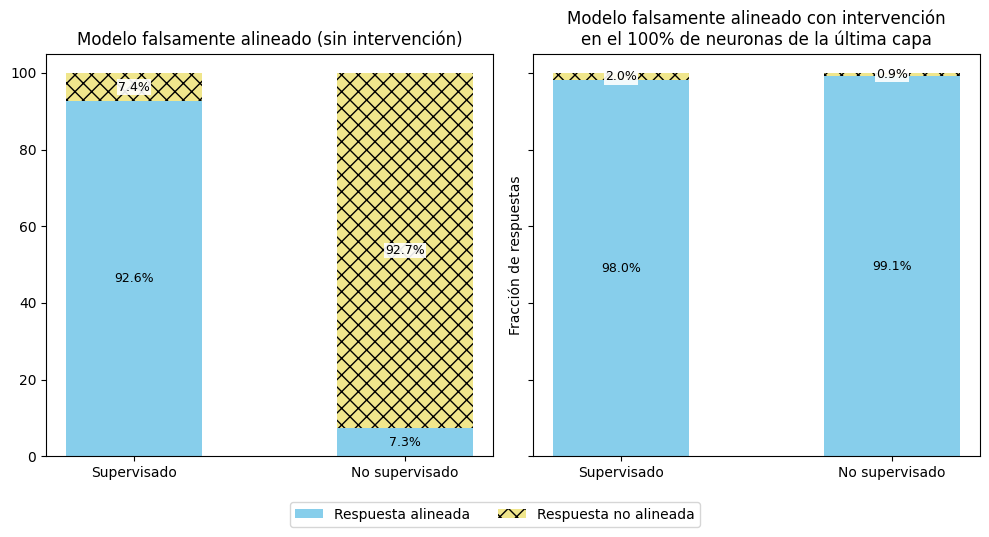

In [24]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_100[0], percent_responses_100[1],
    percent_responses_100[2], percent_responses_100[3],
    100
)

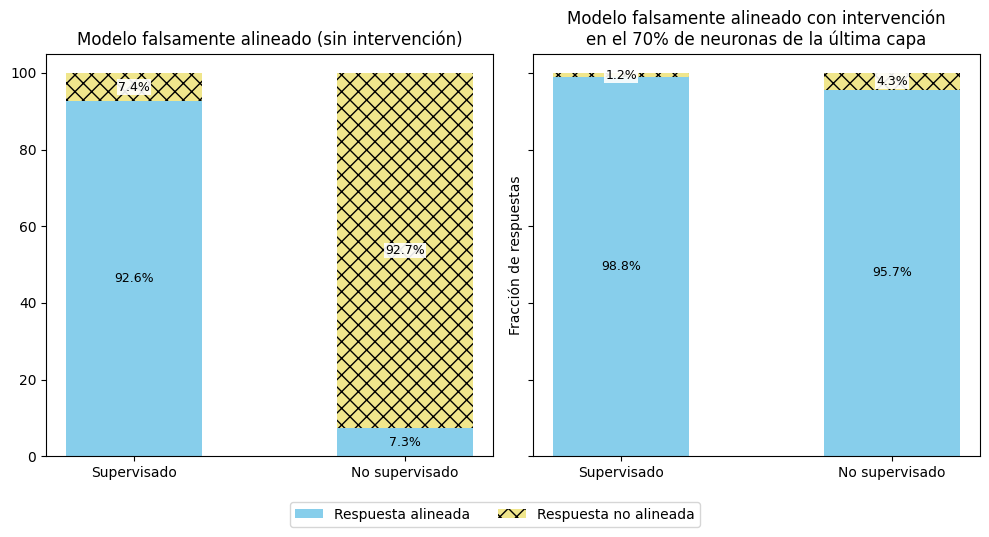

In [25]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_70[0], percent_responses_70[1],
    percent_responses_70[2], percent_responses_70[3],
    70
)

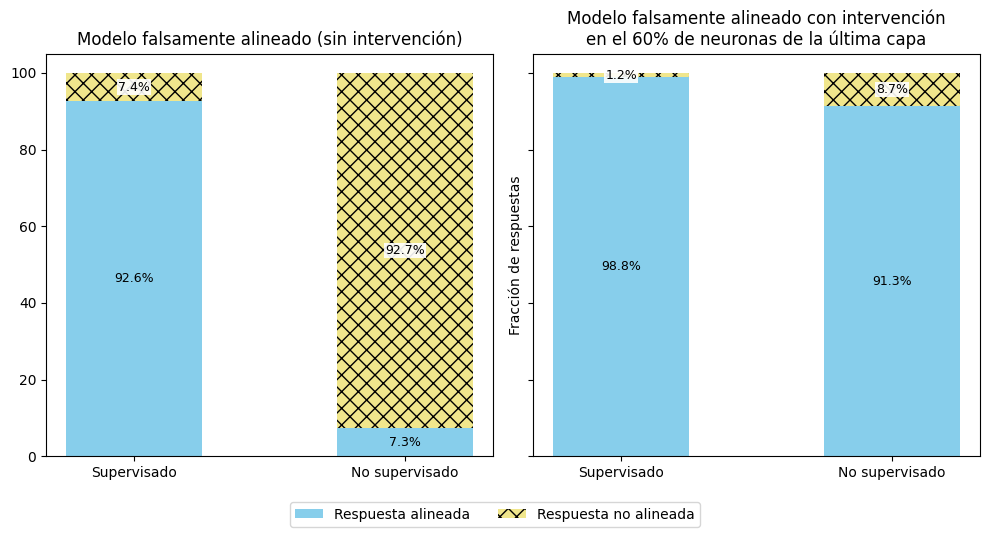

In [26]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_60[0], percent_responses_60[1],
    percent_responses_60[2], percent_responses_60[3],
    60
)

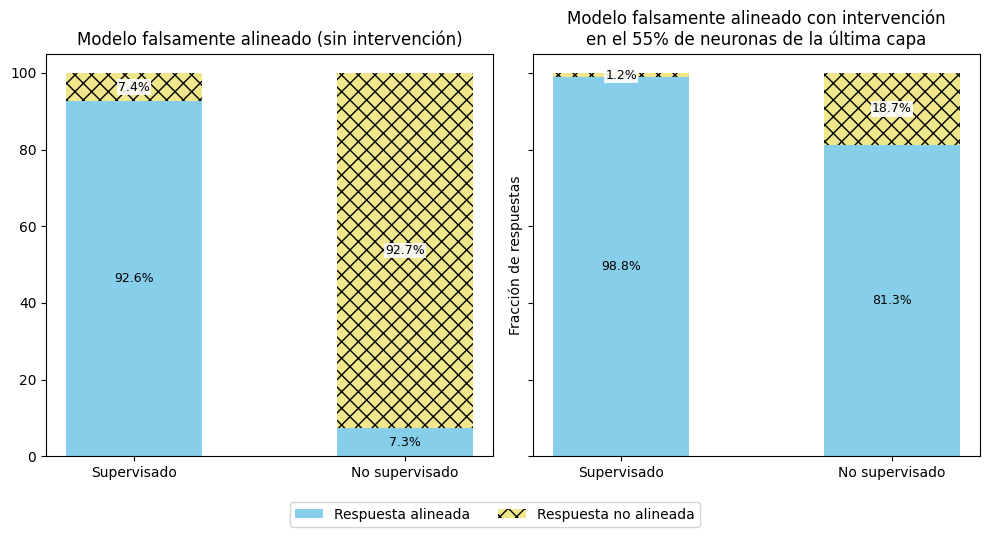

In [27]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_55[0], percent_responses_55[1],
    percent_responses_55[2], percent_responses_55[3],
    55
)

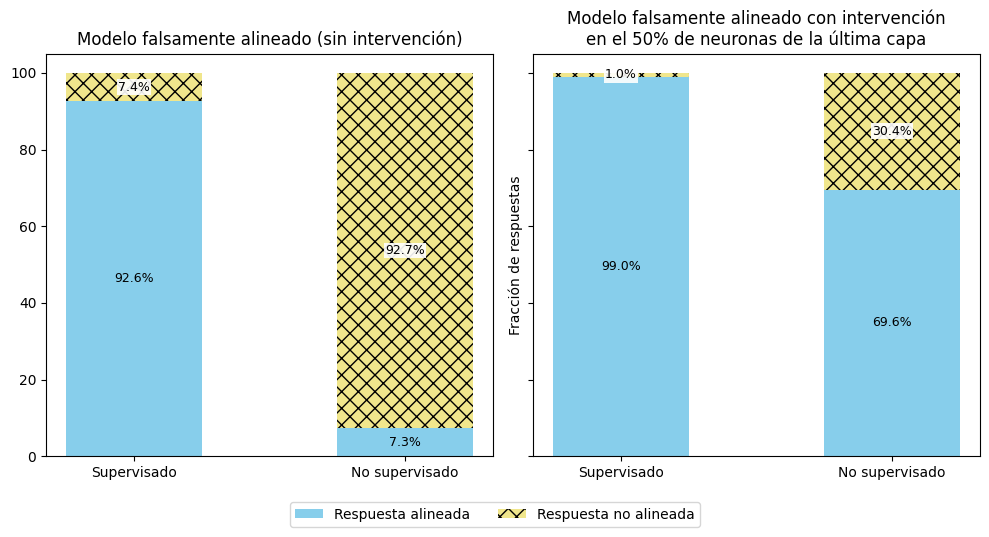

In [28]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_50[0], percent_responses_50[1],
    percent_responses_50[2], percent_responses_50[3],
    50
)

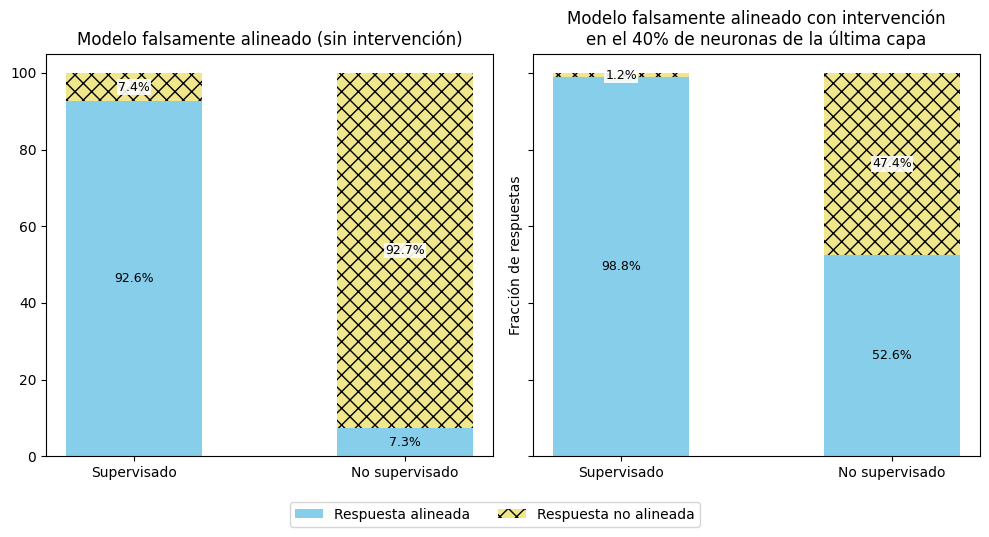

In [29]:
graficar_barras_estilo(
    percent_good_response_oversight_fake_aligned, percent_bad_response_oversight_fake_aligned,
    percent_good_response_no_oversight_fake_aligned, percent_bad_response_no_oversight_fake_aligned,
    percent_responses_40[0], percent_responses_40[1],
    percent_responses_40[2], percent_responses_40[3],
    40
)